<a href="https://colab.research.google.com/github/mahesh-babu-chittem/Machine-Learning-MaheshBabuChittem/blob/main/Lab6_AP23110010084_LinearRegressionEnd2End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Setup & imports
# Run this first in Colab

# Common data science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn for dataset, preprocessing, models, metrics
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# statsmodels for diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# scipy for tests
from scipy.stats import shapiro

# Utilities
import seaborn as sns
sns.set_style("whitegrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Environment ready. Random seed:", RANDOM_SEED)


Environment ready. Random seed: 42


In [ ]:
# Cell 2: Load dataset and record Section A items
cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()

# Basic dataset metadata required by Section A
dataset_name = "California Housing"
source = "sklearn.datasets.fetch_california_housing"
version_date = "sklearn bundled dataset (no explicit version). Fetch date: run-time."
rows, cols = df.shape
target_variable = cal.target_names[0] if hasattr(cal, 'target_names') else 'MedHouseVal'
# We'll set up a train/test split now and record the seed
train_test_split_ratio = 0.8
random_seed = RANDOM_SEED

# Perform the split now
X = df.drop(columns=[target_variable])
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_split_ratio, random_state=random_seed)

print(f"Dataset: {dataset_name}")
print("Source:", source)
print("Rows:", rows, "Columns:", cols)
print("Target:", target_variable)
print("Train/Test split:", f"{int(train_test_split_ratio*100)}%/{int((1-train_test_split_ratio)*100)}%")
print("Random seed:", random_seed)


Dataset: California Housing
Source: sklearn.datasets.fetch_california_housing
Rows: 20640 Columns: 9
Target: MedHouseVal
Train/Test split: 80%/19%
Random seed: 42


In [ ]:
# Cell 3: Preprocessing checks (Section B)

# 1) Standardize column names?
standardize_colnames = True
if standardize_colnames:
    X_train.columns = [c.strip().lower().replace(' ', '_') for c in X_train.columns]
    X_test.columns = X_train.columns

# 2) Remove duplicates and record count
dup_before = len(X_train)
# (Dataset is rows by block; duplicates unlikely but we still check)
train_duplicates = X_train.duplicated().sum()
if train_duplicates > 0:
    X_train = X_train.drop_duplicates()
    y_train = y_train.loc[X_train.index]
dup_after = len(X_train)

# 3) Missing values listing
missing_train = X_train.isna().sum()
missing_test = X_test.isna().sum()

# 4) Choose imputations (dataset has no missing values)
chosen_imputation_numeric = 'none (no missing)'
chosen_imputation_categorical = 'n/a'

# 5) Encoding (no categorical cols by default)
chosen_encoding = 'none (no categorical)'

# 6) Scaling plan
chosen_scaling = 'StandardScaler for numeric features'

# 7) Outlier handling
chosen_outlier_handling = 'None initially. Will review distributions and use IQR if needed.'

# 8) Feature selection/drop plan
chosen_feature_selection = 'Start with all features; use VIF and feature importance to possibly drop.'

# 9) Leakage checks
leakage_checks_performed = True
leakage_notes = 'No obvious leakage — all features collected at block group level and target is house value.'

print("Standardize colnames:", standardize_colnames)
print("Train duplicates before/after:", train_duplicates, "->", dup_after)
print("Missing values (train):")
print(missing_train[missing_train>0])
print("Missing values (test):")
print(missing_test[missing_test>0])
print("Chosen imputation (numeric):", chosen_imputation_numeric)
print("Encoding:", chosen_encoding)
print("Scaling:", chosen_scaling)
print("Outlier handling:", chosen_outlier_handling)
print("Leakage:", leakage_checks_performed, "-", leakage_notes)


Standardize colnames: True
Train duplicates before/after: 0 -> 16512
Missing values (train):
Series([], dtype: int64)
Missing values (test):
Series([], dtype: int64)
Chosen imputation (numeric): none (no missing)
Encoding: none (no categorical)
Scaling: StandardScaler for numeric features
Outlier handling: None initially. Will review distributions and use IQR if needed.
Leakage: True - No obvious leakage — all features collected at block group level and target is house value.


In [ ]:
# Cell 4: Feature inventory quick pass (Section C)
feature_inventory = []
for col in X_train.columns:
    col_type = 'numeric' if pd.api.types.is_numeric_dtype(X_train[col]) else 'categorical'
    missing_pct = X_train[col].isna().mean() * 100
    # impute/encode/scale defaults for numeric
    impute = 'None' if col_type=='numeric' else 'most_frequent'
    encoding = 'None' if col_type=='numeric' else 'OHE/Ordinal'
    scaling = 'Standard' if col_type=='numeric' else 'N/A'
    include = 'Y'
    notes = ''
    feature_inventory.append({
        'feature': col, 'type': col_type, 'missing_%': round(missing_pct,3),
        'impute': impute, 'encoding': encoding, 'scaling': scaling, 'include': include, 'notes': notes
    })

fi_df = pd.DataFrame(feature_inventory)
print("Feature inventory (first rows):")
fi_df


Feature inventory (first rows):


,feature,type,missing_%,impute,encoding,scaling,include,notes
0,medinc,numeric,0.0,None,None,Standard,Y,
1,houseage,numeric,0.0,None,None,Standard,Y,
2,averooms,numeric,0.0,None,None,Standard,Y,
3,avebedrms,numeric,0.0,None,None,Standard,Y,
4,population,numeric,0.0,None,None,Standard,Y,
5,aveoccup,numeric,0.0,None,None,Standard,Y,
6,latitude,numeric,0.0,None,None,Standard,Y,
7,longitude,numeric,0.0,None,None,Standard,Y,


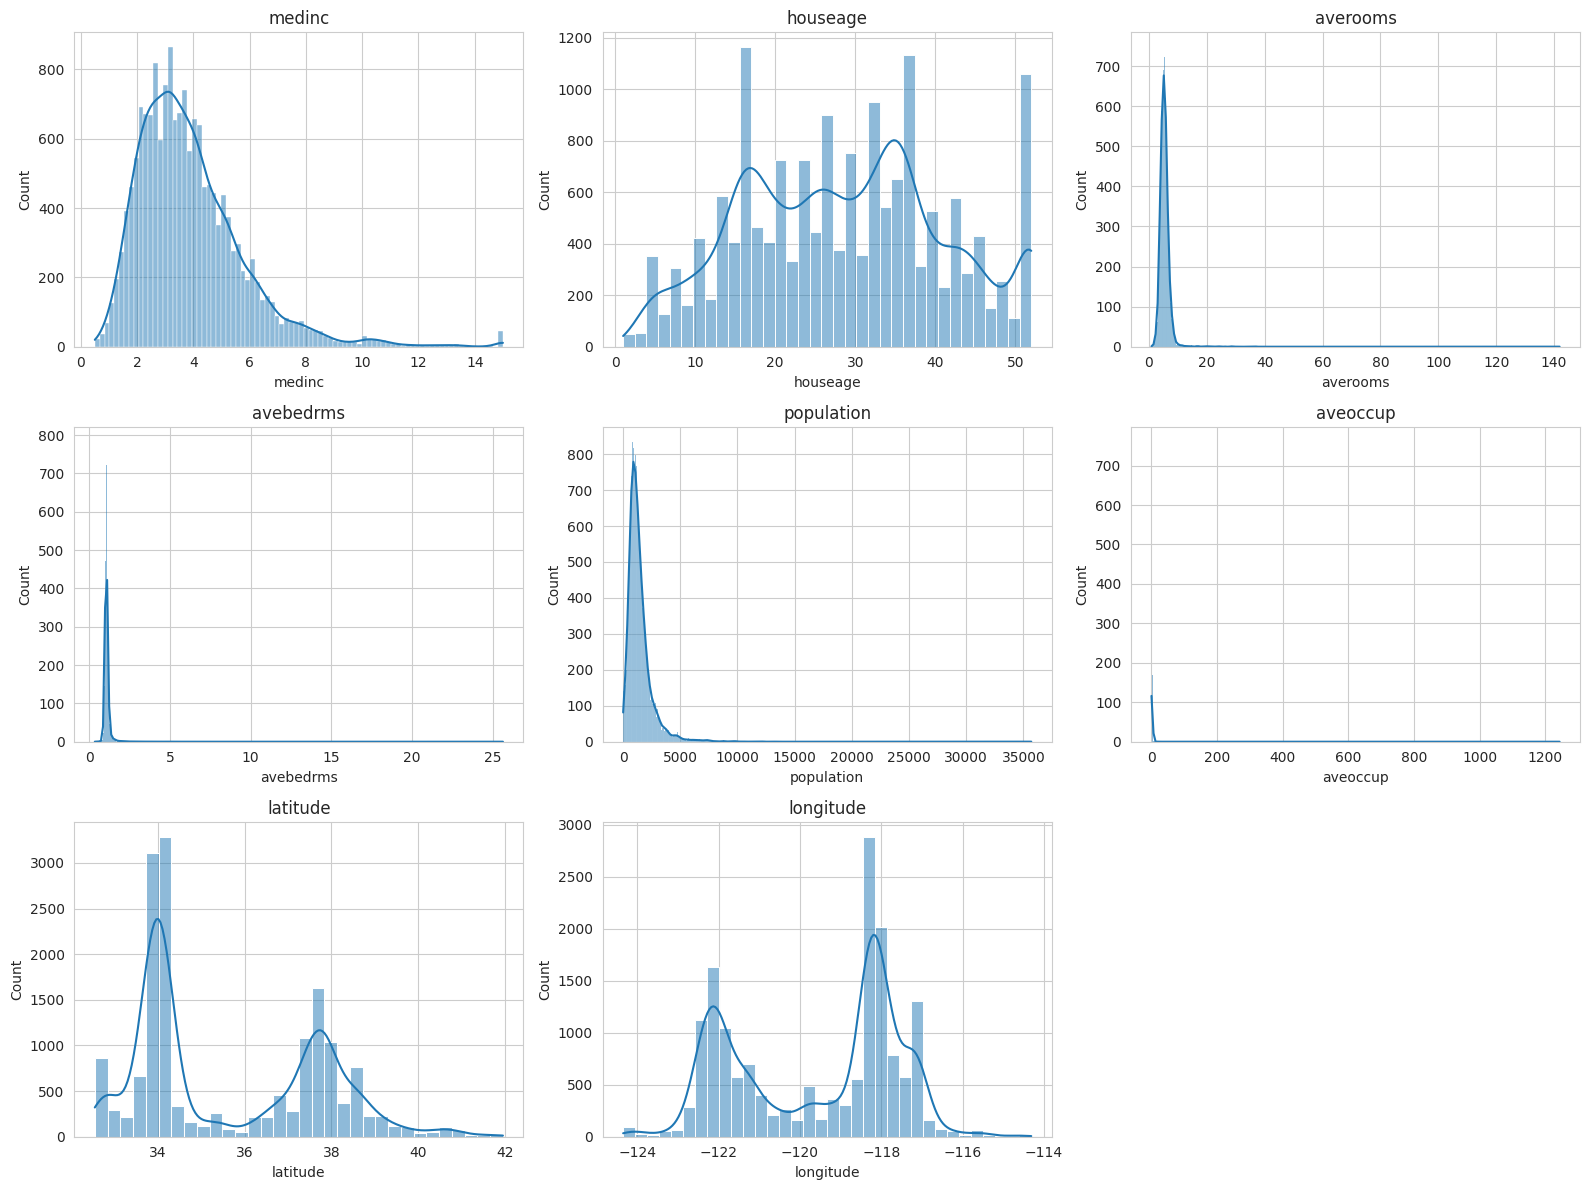

In [ ]:
# Cell 5: EDA - Univariate histograms (Section C1)
# Plot histograms for numeric features and note skew/outliers
numeric_features = X_train.columns.tolist()
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X_train[col], kde=True)
    plt.title(col)
plt.tight_layout()


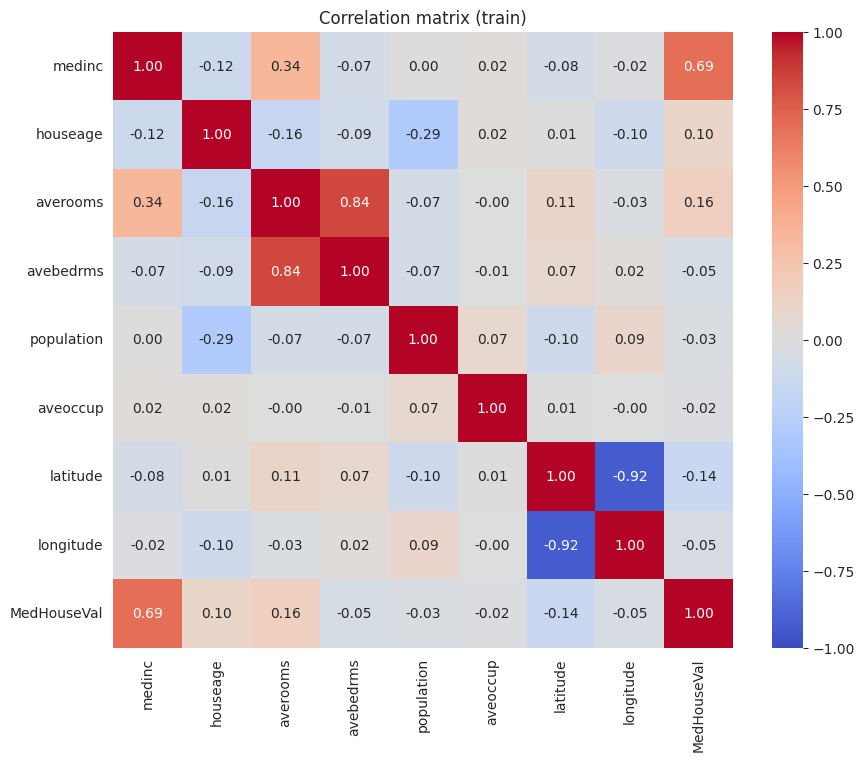

Top features correlated with target: ['medinc', 'averooms', 'latitude', 'houseage', 'avebedrms']


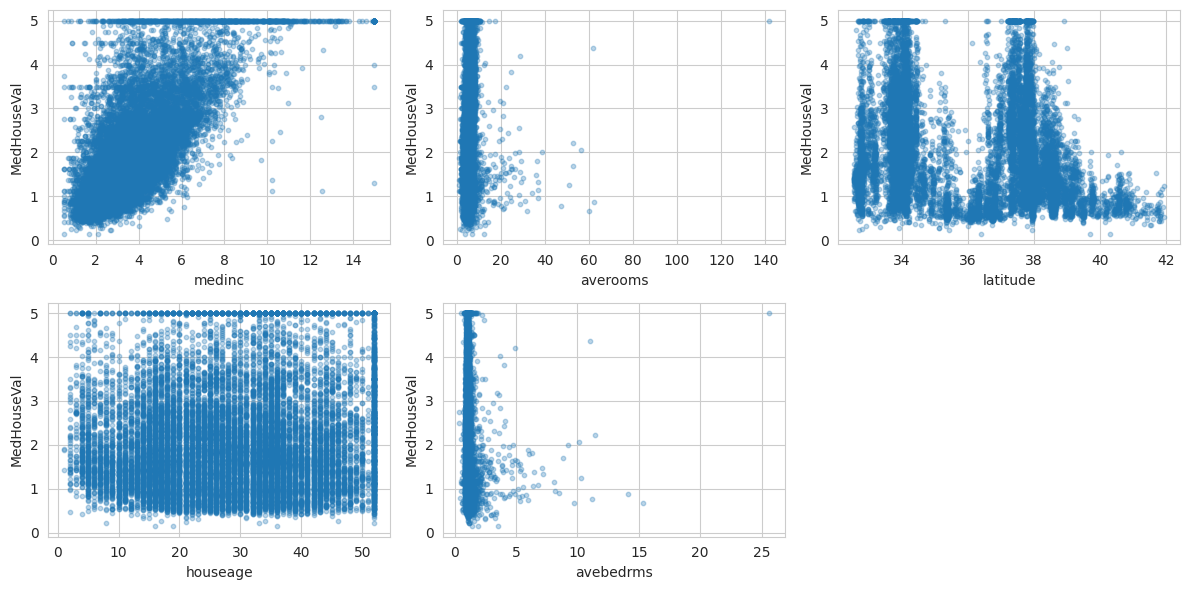

In [ ]:
# Cell 6: EDA - Multivariate (Section C2)
# Correlation matrix (with target)
train_all = X_train.copy()
train_all[target_variable] = y_train
corr = train_all.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (train)")
plt.show()

# Scatter plots of top correlated features vs target
top_corr = corr[target_variable].abs().sort_values(ascending=False).head(6).index.tolist()
top_corr.remove(target_variable)
print("Top features correlated with target:", top_corr)

plt.figure(figsize=(12,6))
for i, col in enumerate(top_corr,1):
    plt.subplot(2,3,i)
    plt.scatter(X_train[col], y_train, alpha=0.3, s=10)
    plt.xlabel(col); plt.ylabel(target_variable)
plt.tight_layout()


In [ ]:
# Cell 7: Linear regression setup (Section D - first row)
# Start with the features from Section C (all numeric features)
features_start = X_train.columns.tolist()
print("Starting features for linear regression:", features_start)

# Pipeline: StandardScaler + LinearRegression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
pipeline_lr.fit(X_train[features_start], y_train)

print("Linear regression model trained on training data.")


Starting features for linear regression: ['medinc', 'houseage', 'averooms', 'avebedrms', 'population', 'aveoccup', 'latitude', 'longitude']
Linear regression model trained on training data.


In [ ]:
# Cell 8 (fixed): Compute metrics
def regression_metrics(model, X_tr, y_tr, X_te, y_te, features):
    preds_tr = model.predict(X_tr[features])
    preds_te = model.predict(X_te[features])

    mse_train = mean_squared_error(y_tr, preds_tr)
    mse_test = mean_squared_error(y_te, preds_te)

    metrics = {
        'mae_train': mean_absolute_error(y_tr, preds_tr),
        'mse_train': mse_train,
        'rmse_train': np.sqrt(mse_train),
        'r2_train': r2_score(y_tr, preds_tr),
        'mae_test': mean_absolute_error(y_te, preds_te),
        'mse_test': mse_test,
        'rmse_test': np.sqrt(mse_test),
        'r2_test': r2_score(y_te, preds_te),
    }
    metrics['train_test_gap_r2'] = metrics['r2_train'] - metrics['r2_test']
    return metrics

metrics_lr = regression_metrics(pipeline_lr, X_train, y_train, X_test, y_test, features_start)
metrics_lr

{'mae_train': 0.5286283596581934,
 'mse_train': 0.5179331255246699,
 'rmse_train': np.float64(0.7196757085831575),
 'r2_train': 0.6125511913966952,
 'mae_test': 0.5332001304956565,
 'mse_test': 0.5558915986952442,
 'rmse_test': np.float64(0.7455813830127763),
 'r2_test': 0.575787706032451,
 'train_test_gap_r2': 0.03676348536424423}

In [ ]:
# Cell 9: Interpretability - top coefficients (Section D - third row)
# Get coefficients from the trained pipeline (after scaling)
coeffs = pipeline_lr.named_steps['lr'].coef_
coef_df = pd.DataFrame({'feature': features_start, 'coef': coeffs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False)

print("Top coefficients (magnitude):")
coef_df_sorted.head(10)
# Plain-English note (write in notebook): e.g., positive coef for medinc -> higher median income -> higher house value.

Top coefficients (magnitude):


,feature,coef,abs_coef
6,latitude,-0.896929,0.896929
7,longitude,-0.869842,0.869842
0,medinc,0.854383,0.854383
3,avebedrms,0.339259,0.339259
2,averooms,-0.294410,0.294410
1,houseage,0.122546,0.122546
5,aveoccup,-0.040829,0.040829
4,population,-0.002308,0.002308


In [ ]:
# Cell 10: Multicollinearity & assumptions (Section E)

# VIF calculation requires a constant column for statsmodels
X_vif = sm.add_constant(StandardScaler().fit_transform(X_train[features_start]))
vif_data = pd.DataFrame()
vif_data['feature'] = ['const'] + features_start
vif_data['VIF'] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
print("Top VIFs:")
vif_data.sort_values('VIF', ascending=False).head(10)

# Residuals: fit an OLS using statsmodels to get residual diagnostics
X_train_sm = sm.add_constant(X_train[features_start])
model_sm = sm.OLS(y_train, X_train_sm).fit()
residuals = model_sm.resid

# Shapiro-Wilk for normality of residuals (be careful: large samples -> may be significant)
shapiro_stat, shapiro_p = shapiro(residuals.sample(min(5000, len(residuals)), random_state=RANDOM_SEED))
dw_stat = durbin_watson(residuals)
bp_test = het_breuschpagan(residuals, model_sm.model.exog)
bp_pvalue = bp_test[3]

print(f"Shapiro-Wilk p-value (sampled): {shapiro_p:.4g}")
print(f"Durbin-Watson: {dw_stat:.4f}")
print(f"Breusch-Pagan p-value (heteroscedasticity): {bp_pvalue:.4g}")

# Overall: Pass / Needs Work decision (simple heuristic)
assumptions_summary = {
    'vif_top': vif_data.sort_values('VIF', ascending=False).head(3),
    'shapiro_p': shapiro_p,
    'durbin_watson': dw_stat,
    'breusch_pagan_p': bp_pvalue
}
assumptions_summary

Top VIFs:
Shapiro-Wilk p-value (sampled): 3.38e-43
Durbin-Watson: 1.9618
Breusch-Pagan p-value (heteroscedasticity): 1.088e-256


{'vif_top':      feature       VIF
 7   latitude  9.206134
 8  longitude  8.875984
 3   averooms  7.917240,
 'shapiro_p': np.float64(3.379848804338216e-43),
 'durbin_watson': np.float64(1.9617928318577218),
 'breusch_pagan_p': np.float64(1.0882774452552616e-256)}

In [ ]:
# Cell 11: Tuning F1 - Polynomial features for strongest feature (Section F1)
# Choose a strong feature discovered earlier. We'll pick 'MedInc' equivalent (median income is 'MedInc' -> in sklearn name: 'MedInc')
# But our column names are lowercased; check exact col name:
print("Columns:", X_train.columns.tolist())

# Identify a top correlated numeric feature by correlation
corr_with_target = train_all.corr()[target_variable].abs().sort_values(ascending=False)
strong_feature = corr_with_target.drop(target_variable).index[0]
print("Selected strong feature for polynomial tuning:", strong_feature)

# Try degrees 1..5 and evaluate via cross-validated R2
from sklearn.model_selection import cross_val_score
best_degree = None
best_score = -np.inf
scores_by_degree = {}
for deg in range(1,6):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    # pipeline: scale other features as usual but create polynomial for only the selected feature
    X_train_local = X_train.copy()
    poly_feats = poly.fit_transform(X_train_local[[strong_feature]])
    # create combined dataframe
    poly_cols = [f"{strong_feature}_deg{deg}_{i}" for i in range(poly_feats.shape[1])]
    X_poly_df = pd.DataFrame(poly_feats, index=X_train_local.index, columns=poly_cols)
    X_comb = pd.concat([X_train_local.drop(columns=[strong_feature]), X_poly_df], axis=1)
    model = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
    cv_scores = cross_val_score(model, X_comb, y_train, cv=5, scoring='r2')
    mean_cv = cv_scores.mean()
    scores_by_degree[deg] = mean_cv
    if mean_cv > best_score:
        best_score = mean_cv
        best_degree = deg

print("CV R2 by degree:", scores_by_degree)
print("Best degree:", best_degree, "with CV R2:", best_score)

Columns: ['medinc', 'houseage', 'averooms', 'avebedrms', 'population', 'aveoccup', 'latitude', 'longitude']
Selected strong feature for polynomial tuning: medinc
CV R2 by degree: {1: np.float64(0.6114839952560993), 2: np.float64(0.616848224895415), 3: np.float64(0.6282636106978547), 4: np.float64(0.6283526745800833), 5: np.float64(0.6288721560912007)}
Best degree: 5 with CV R2: 0.6288721560912007


In [ ]:
# Cell 12: Tuning F2 - Encoding impact
# The dataset has no categorical features; create one by binning 'median income' into categories
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
bin_col = 'medinc_cat'
X_train_enc[bin_col] = pd.qcut(X_train_enc[strong_feature], q=4, labels=['low','med','high','very_high'])
X_test_enc[bin_col]  = pd.qcut(X_test_enc[strong_feature], q=4, labels=['low','med','high','very_high'])

# Prepare three pipelines: no encoding (drop cat), ordinal, one-hot
results_encoding = {}

# 1) Drop categorical (baseline)
pipe_drop = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
# drop the created bin column
pipe_drop.fit(X_train_enc.drop(columns=[bin_col]), y_train)
results_encoding['drop'] = regression_metrics(pipe_drop, X_train_enc.drop(columns=[bin_col]), y_train, X_test_enc.drop(columns=[bin_col]), y_test, X_train_enc.drop(columns=[bin_col]).columns.tolist())

# 2) Ordinal encoding
ord_enc = OrdinalEncoder()
X_train_ord = X_train_enc.copy()
X_test_ord = X_test_enc.copy()
X_train_ord[bin_col] = ord_enc.fit_transform(X_train_ord[[bin_col]])
X_test_ord[bin_col]  = ord_enc.transform(X_test_ord[[bin_col]])
pipe_ord = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_ord.fit(X_train_ord, y_train)
results_encoding['ordinal'] = regression_metrics(pipe_ord, X_train_ord, y_train, X_test_ord, y_test, X_train_ord.columns.tolist())

# 3) One-hot encoding (use pandas get_dummies)
X_train_ohe = pd.get_dummies(X_train_enc, columns=[bin_col], drop_first=True)
X_test_ohe  = pd.get_dummies(X_test_enc, columns=[bin_col], drop_first=True)
# ensure same columns
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)
pipe_ohe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_ohe.fit(X_train_ohe, y_train)
results_encoding['onehot'] = regression_metrics(pipe_ohe, X_train_ohe, y_train, X_test_ohe, y_test, X_train_ohe.columns.tolist())

results_encoding

{'drop': {'mae_train': 0.5286283596581934,
  'mse_train': 0.5179331255246699,
  'rmse_train': np.float64(0.7196757085831575),
  'r2_train': 0.6125511913966952,
  'mae_test': 0.5332001304956565,
  'mse_test': 0.5558915986952442,
  'rmse_test': np.float64(0.7455813830127763),
  'r2_test': 0.575787706032451,
  'train_test_gap_r2': 0.03676348536424423},
 'ordinal': {'mae_train': 0.5276484178318617,
  'mse_train': 0.517062363920878,
  'rmse_train': np.float64(0.7190704860588272),
  'r2_train': 0.6132025796345586,
  'mae_test': 0.5334613472061498,
  'mse_test': 0.5552534144929171,
  'rmse_test': np.float64(0.7451532825485755),
  'r2_test': 0.5762747175020944,
  'train_test_gap_r2': 0.03692786213246424},
 'onehot': {'mae_train': 0.5284880701051253,
  'mse_train': 0.5142570702130854,
  'rmse_train': np.float64(0.717117194197075),
  'r2_train': 0.6153011279824085,
  'mae_test': 0.5345941576679198,
  'mse_test': 0.5548980052569586,
  'rmse_test': np.float64(0.7449147637528462),
  'r2_test': 0.57

In [ ]:
# Cell 13: Tuning F3 - Regularization
from sklearn.model_selection import GridSearchCV

# We'll use the full set of numeric features (or one-hot if chosen earlier)
X_for_reg = X_train.copy()
X_for_reg_test = X_test.copy()
X_for_reg_sc = StandardScaler().fit_transform(X_for_reg)

# Ridge
ridge = Ridge(random_state=RANDOM_SEED)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}
grid_ridge = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
grid_ridge.fit(X_for_reg_sc, y_train)
best_ridge_alpha = grid_ridge.best_params_['alpha']
best_ridge_score = grid_ridge.best_score_

# Lasso (note: scale input)
lasso = Lasso(max_iter=10000, random_state=RANDOM_SEED)
grid_lasso = GridSearchCV(lasso, {'alpha': alphas}, scoring='r2', cv=5)
grid_lasso.fit(X_for_reg_sc, y_train)
best_lasso_alpha = grid_lasso.best_params_['alpha']
best_lasso_score = grid_lasso.best_score_

# Fit best models and evaluate on test set
ridge_best = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=best_ridge_alpha, random_state=RANDOM_SEED))])
ridge_best.fit(X_for_reg, y_train)
lasso_best = Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=RANDOM_SEED))])
lasso_best.fit(X_for_reg, y_train)

metrics_ridge = regression_metrics(ridge_best, X_for_reg, y_train, X_for_reg_test, y_test, X_for_reg.columns.tolist())
metrics_lasso = regression_metrics(lasso_best, X_for_reg, y_train, X_for_reg_test, y_test, X_for_reg.columns.tolist())

# For Lasso: number of non-zero coefficients (after scaling model inside pipeline)
coefs_lasso = lasso_best.named_steps['model'].coef_
non_zero = np.sum(np.abs(coefs_lasso) > 1e-6)

summary_reg = {
    'ridge': {'best_alpha': best_ridge_alpha, 'cv_r2': best_ridge_score, 'test_metrics': metrics_ridge},
    'lasso': {'best_alpha': best_lasso_alpha, 'cv_r2': best_lasso_score, 'test_metrics': metrics_lasso, 'n_nonzero_coefs': int(non_zero)}
}
summary_reg

{'ridge': {'best_alpha': 0.001,
  'cv_r2': np.float64(0.6114839952527685),
  'test_metrics': {'mae_train': 0.5286283554884892,
   'mse_train': 0.5179331255247629,
   'rmse_train': np.float64(0.7196757085832222),
   'r2_train': 0.6125511913966255,
   'mae_test': 0.5332001233368299,
   'mse_test': 0.5558915618350115,
   'rmse_test': np.float64(0.745581358293655),
   'r2_test': 0.5757877341612514,
   'train_test_gap_r2': 0.03676345723537411}},
 'lasso': {'best_alpha': 0.001,
  'cv_r2': np.float64(0.6114974494713218),
  'test_metrics': {'mae_train': 0.5287025571161695,
   'mse_train': 0.5179889798690679,
   'rmse_train': np.float64(0.7197145127542364),
   'r2_train': 0.6125094085909122,
   'mae_test': 0.5331447750392391,
   'mse_test': 0.5544913600832686,
   'rmse_test': np.float64(0.7446417662764214),
   'r2_test': 0.5768562568705682,
   'train_test_gap_r2': 0.035653151720344},
  'n_nonzero_coefs': 8}}

LinearRegression CV R2 mean/std: 0.611456745810643 0.012358719496266588
Ridge CV R2 mean/std: 0.6114567464528805 0.012358717879956516


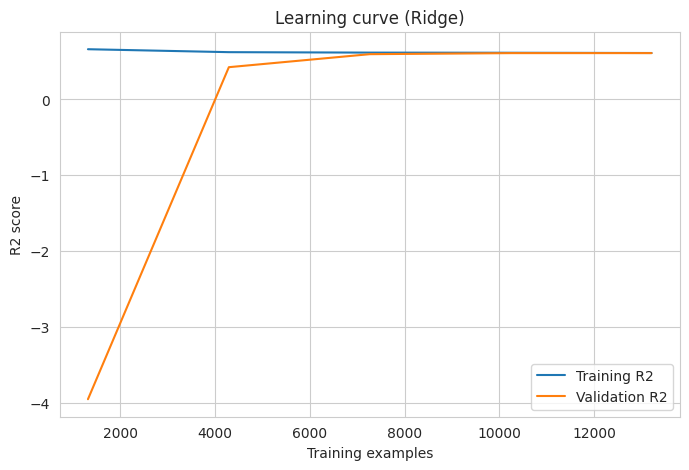

In [ ]:
# Cell 14: CV and learning curve (Section F4)
# K-Fold CV for final chosen model: we'll evaluate LinearRegression baseline and Ridge best

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
lr_cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=kf, scoring='r2')
ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=summary_reg['ridge']['best_alpha']))])
ridge_cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=kf, scoring='r2')

print("LinearRegression CV R2 mean/std:", lr_cv_scores.mean(), lr_cv_scores.std())
print("Ridge CV R2 mean/std:", ridge_cv_scores.mean(), ridge_cv_scores.std())

# Learning curve for Ridge
train_sizes, train_scores, test_scores = learning_curve(ridge_pipeline, X_train, y_train, cv=5, scoring='r2',
                                                       train_sizes=np.linspace(0.1,1.0,5), random_state=RANDOM_SEED)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, label='Training R2')
plt.plot(train_sizes, test_scores_mean, label='Validation R2')
plt.xlabel("Training examples")
plt.ylabel("R2 score")
plt.legend()
plt.title("Learning curve (Ridge)")
plt.grid(True)
plt.show()

# Bias/variance note: deduce from plots and CV scores and write in Section F4.

In [ ]:
# Cell 15: Final Summary & Reflection (Section G)
# Choose final model: compare test R2 for baseline LR vs Ridge vs Lasso (from earlier)
final_candidates = {
    'LinearRegression': metrics_lr,
    'Ridge': summary_reg['ridge']['test_metrics'],
    'Lasso': summary_reg['lasso']['test_metrics']
}

for k,v in final_candidates.items():
    print(k, "-> R2_test:", v['r2_test'], "RMSE_test:", v['rmse_test'], "MAE_test:", v['mae_test'])

# Choose best by highest R2_test
best_model_name = max(final_candidates.items(), key=lambda x: x[1]['r2_test'])[0]
print("Chosen final model:", best_model_name)

# Top 3 drivers (from coef magnitudes)
if best_model_name == 'LinearRegression':
    chosen_coef_df = coef_df_sorted
elif best_model_name == 'Ridge':
    coefs = ridge_best.named_steps['model'].coef_
    chosen_coef_df = pd.DataFrame({'feature': X_for_reg.columns, 'coef': coefs}).assign(abs_coef=lambda d: d['coef'].abs()).sort_values('abs_coef', ascending=False)
else:
    coefs = lasso_best.named_steps['model'].coef_
    chosen_coef_df = pd.DataFrame({'feature': X_for_reg.columns, 'coef': coefs}).assign(abs_coef=lambda d: d['coef'].abs()).sort_values('abs_coef', ascending=False)

print("Top 3 driver features:")
print(chosen_coef_df.head(3))

print("\nLimitations / ethics / next steps:")
print("- Model is linear; non-linearities may be present. Consider tree-based or ensemble models.")
print("- Spatial/autocorrelation not explicitly modeled (nearby blocks may have correlated values).")
print("- Income/household composition changes over time; dataset snapshot may not reflect temporal changes.")
print("- Next steps: incorporate geo features, external economic indicators, or ensemble methods; try feature interactions.")

LinearRegression -> R2_test: 0.575787706032451 RMSE_test: 0.7455813830127763 MAE_test: 0.5332001304956565
Ridge -> R2_test: 0.5757877341612514 RMSE_test: 0.745581358293655 MAE_test: 0.5332001233368299
Lasso -> R2_test: 0.5768562568705682 RMSE_test: 0.7446417662764214 MAE_test: 0.5331447750392391
Chosen final model: Lasso
Top 3 driver features:
     feature      coef  abs_coef
6   latitude -0.885822  0.885822
7  longitude -0.858093  0.858093
0     medinc  0.849140  0.849140

Limitations / ethics / next steps:
- Model is linear; non-linearities may be present. Consider tree-based or ensemble models.
- Spatial/autocorrelation not explicitly modeled (nearby blocks may have correlated values).
- Income/household composition changes over time; dataset snapshot may not reflect temporal changes.
- Next steps: incorporate geo features, external economic indicators, or ensemble methods; try feature interactions.
